Study sentiment in data set of tweets collected during COVID-19 pandemic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Load dataset 

In [2]:
def grab_tweets():
    """
    The user supplied these data already split into training and test sets. 
    This function downloads and combines them, returning a single data frame.
    No arguments. 
    """

    url1 = "https://raw.githubusercontent.com/PhilChodrow/PIC16A/master/datasets/Corona_NLP_train.csv"
    url2 = "https://raw.githubusercontent.com/PhilChodrow/PIC16A/master/datasets/Corona_NLP_test.csv"
    
    df1 = pd.read_csv(url1, encoding='iso-8859-1')
    df2 = pd.read_csv(url2, encoding='iso-8859-1')
    
    return pd.concat((df1, df2), axis = 0).reset_index().drop("index", axis = 1)

df = grab_tweets()

In [3]:
train_url = "https://raw.githubusercontent.com/PhilChodrow/PIC16A/master/datasets/Corona_NLP_train.csv"
test_url = "https://raw.githubusercontent.com/PhilChodrow/PIC16A/master/datasets/Corona_NLP_test.csv"

train = pd.read_csv(train_url, encoding='iso-8859-1')
test = pd.read_csv(test_url, encoding='iso-8859-1')

# Data Exploratory and Strategy
Data set included: UserName, ScreenName, Location, TweetAt, OriginalTweet, Sentiment.
For the sentiment analysis, discard the other column aside from OriginalTweet and Sentiment.

In [4]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
train.shape, test.shape

((41157, 6), (3798, 6))

In [6]:
summary = train.groupby(['Sentiment'])[['OriginalTweet']].count()
summary['% Tweets'] = summary.apply(lambda x: 100*x/ x.sum()).round(1)
summary = summary.rename({'OriginalTweet': 'Count'}, axis=1)
summary

,Count,% Tweets
Sentiment,,
Extremely Negative,5481,13.3
Extremely Positive,6624,16.1
Negative,9917,24.1
Neutral,7713,18.7
Positive,11422,27.8


Text(0, 0.5, 'Count')

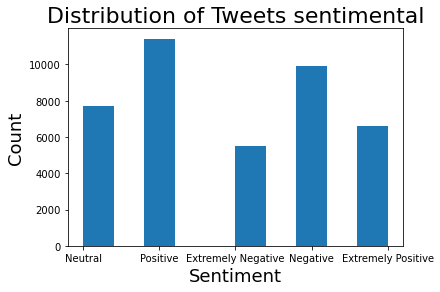

In [7]:
plt.hist(train['Sentiment'],bins=10)
plt.title("Distribution of Tweets sentimental", fontsize=22)
plt.xlabel("Sentiment", fontsize=18)
plt.ylabel("Count", fontsize=18)

From the distribution graph and the summary table, I can assume and this is classifying for binary data. 

For the sentiment analysis, discard the other column aside from `OriginalTweet` and `Sentiment`.<br>
**Strategy:**
* Use CountVectorizer to created a term-document matrix. Treat each tweet as a document.
* Clean data and simplifying `Sentiment`
* Split data into training and test set
* Find the optimal complexity parameter for the classifier of choice (Logistic Regression)
* Fit data on training set
* Display test score (#2)
* Display 10 most negative and most positive words (#3)
* Display tweets that the model make a mistake (#4)

# Create term-document matrix
Discarded the 'neutrals' rows and recode:

Extremely Negative and Negative as 0
Extremely Positive and Positive as 1
This is because the classifier is taking a little too long to process and classify for the original data.

In [8]:
# Combine train and test data into a single data frame
df = pd.concat((train, test), axis = 0).reset_index().drop("index", axis = 1)
df.shape

(44955, 6)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(max_df = 0.2, min_df = 30, stop_words = 'english')

counts = vec.fit_transform(df['OriginalTweet'])
count_df = pd.DataFrame(counts.toarray(), columns = vec.get_feature_names())

In [10]:
df = df = pd.concat((df, count_df), axis = 1)
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,00,000,03,10,...,yesterday,yo,york,young,youtube,youâ,yâ,zealand,zero,zombie
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44950,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44951,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44952,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44953,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Clean Data and Simplifying Sentiment
Discarded the 'neutrals' rows and recode:
- Extremely Negative and Negative as 0
- Extremely Positive and Positive as 1

This is because the classifier is taking a little too long to process and classify for the original data.


In [11]:
def clean_data(df):
    """
    Encode Sentiment of Extremely and normal positive/negative into 1
    Discarded the neutral sentiment
    """
    df = df.copy()
    recode = {'Positive': 0, 'Extremely Positive': 0, 'Negative': 1, 'Extremely Negative': 1}
    
    df = df[df.Sentiment != 'Neutral']
    df['Sentiment'] = df['Sentiment'].map(recode)
    
    return df

In [12]:
DF = clean_data(df)
DF.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,00,000,03,10,...,yesterday,yo,york,young,youtube,youâ,yâ,zealand,zero,zombie
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Split Data

In [13]:
X = DF.drop(['UserName', 'ScreenName','Location', 'TweetAt', 'OriginalTweet', 'Sentiment'], axis = 1)
y = DF['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Find optimal complexity parameter 

In [14]:
best_score = 0

for C in np.linspace(0.1, 1, 10):
    LR  = LogisticRegression (C = C, max_iter = 200)
    cv_score = cross_val_score(LR, X_train, y_train, cv = 5).mean()
    if cv_score > best_score:
        best_C = C
        best_score = cv_score
print('optimal complexity parameter C =', best_C,' with CV score = ', best_score)

optimal complexity parameter C = 0.6  with CV score =  0.8440820065421717


# Show that your model can make predictions of sentiment on unseen tweets

In [17]:
LR = LogisticRegression(C= best_score, max_iter = 200)
LR.fit(X_train, y_train)
LR.score(X_train, y_train), LR.score(X_test, y_test)

(0.908888180949347, 0.8488737201365187)

In [18]:
result_df = pd.DataFrame({'coef': LR.coef_[0], 'word': X_train.columns})

In [19]:
# most Positive words (positive = 0) so ascending = True
result_df.sort_values('coef', ascending = True).head(10)

,coef,word
304,-3.346293,best
1293,-3.073930,great
3208,-3.017718,won
604,-2.950024,confidence
2163,-2.890979,positive
1328,-2.881878,hand
1201,-2.759442,free
1725,-2.557789,love
2077,-2.545133,perfect
368,-2.520726,brilliant


In [20]:
# most Negative words (negative = 1) so descending
result_df.sort_values('coef', ascending = False).head(10)

,coef,word
728,3.598605,crisis
827,3.124340,died
2514,3.023991,scams
1369,2.868279,hell
1590,2.826638,kill
1183,2.739420,forced
2622,2.694133,sick
846,2.670053,disaster
1592,2.648757,killing
2512,2.615061,scam


# Display three tweets in which your model made a mistake -- e.g. it classified the tweet as positive when in fact it was negative, or vice-versa.


In [21]:
y_test_pred = LR.predict(X_test)

mistake_df = pd.DataFrame(DF[['OriginalTweet']].loc[X_test.index])
mistake_df['True Sentiment'] = y_test
mistake_df['Predict'] = y_test_pred
mistake_df = mistake_df[mistake_df['True Sentiment'] != mistake_df['Predict']]
mistake_df

,OriginalTweet,True Sentiment,Predict
33124,Most innovative sanitizer Spray ????\r\r\n\r\r...,0,1
34728,When Kid Cudi said ÂHaters shake my hand but ...,1,0
42215,Me at the grocery store looking to buy a large...,0,1
37538,Maybe grocery store rig. #COVID?19 #SocialDis...,1,0
18232,Is there a sanitizer like substance that could...,1,0
...,...,...,...
12524,"HUL reduces prices of Lifebuoy sanitizers, Liq...",0,1
13495,Supermarket In #Denmark Uses Price Trick To St...,1,0
7146,@realDonaldTrump New law: Nurses and Grocery s...,1,0
1194,#Australia can you please share photos of all ...,0,1


In [41]:
mistake_df.iloc[0].values

array(['Most innovative sanitizer Spray ????\r\r\n\r\r\n.\r\r\n.\r\r\n\r\r\n#Coronavirus #CoronaAlert #CoronaOutbreak #Corona  #COVID19 #CoronaVirusSafety #CoronavirusEffect #coronaviruscure #businesslife #wfh #CoronavirusLockdown #LockdownNow #StayAtHomeOrder #CoronavirusPandemic #coronaspread #pandemic https://t.co/3cBCuCNKKT',
       0, 1], dtype=object)

In [42]:
mistake_df.iloc[5].values

array(["Today at the grocery store I saw someone getting a case of #Corona beer and I was about to jokingly say 'hey man i see you got Corona' then I stopped myself doing that thinking it would be the new version of yelling fire in a movie theater #COVID2019 #COVID19 #QuarantineLife",
       1, 0], dtype=object)

In [43]:
mistake_df.iloc[15].values

array(["Please don't stockpile supermarket toilet paper - you can purchase on bulk from cleaning or janitorial suppliers \r\r\nhttps://t.co/rPHYzXrgOm\r\r\n#hoarders #CoronaCrisis #CoronaVirusUpdate",
       0, 1], dtype=object)